Notebook copied from /Users/fkutschera/Documents/Data/CRESCENT to https://github.com/fabian-kutschera/Benchmarks/tree/main for future reference.

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

In [11]:
# Folder where the processed receivers will be saved
output_folder = "/Users/fkutschera/Documents/Data/CRESCENT/tpv36_data/kutschera_SCEC_v2_o4_David_RR/"
# Create the folder if it doesn't exist
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

# Converting processes SeisSol surface deformation (after ParaView) 

1. Load surface-xdmf in ParaView
2. Go to last time step
3. Apply Cell Data to Point Data Filter
4. Select Save Data (_surfdef_v1_SeisSol.csv_)


In [12]:
df = pd.read_csv("/Users/fkutschera/Documents/Data/CRESCENT/tpv36_data/tpv36_SCEC_v2_o4_David_RR/surfdef_SeisSol.csv")

df.rename({"u1": "h-disp", "u2": "n-disp", "u3": "v-disp", "Points:0": "x", "Points:1": "z"}, axis=1, inplace=True)
df = df.loc[:,["x", "z", "h-disp", "v-disp", "n-disp"]] # re-order columns
df = df[df["x"] >= -30000]
df = df[df["x"] <= 30000]
df = df[df["z"] >= -15000]
df = df[df["z"] <= 53000]
# Sign convention: Positive means displacement downward relative to the node's initial position (that is, in the +y direction)
df["v-disp"] *= -1
df

,x,z,h-disp,v-disp,n-disp
1488088,27849.0,-11300.0,0.007681,-0.026527,0.066504
1488089,27762.0,-11250.0,0.007524,-0.027672,0.066397
1488090,27762.0,-11350.0,0.007550,-0.027421,0.066722
1488091,27791.0,-11300.0,0.007593,-0.027196,0.066535
1488092,27705.0,-11150.0,0.007302,-0.028699,0.066177
...,...,...,...,...,...
5915915,20574.0,23000.0,-0.087130,0.066048,-0.158170
5915916,15638.0,28250.0,-0.222460,0.181230,-0.406710
5915917,15725.0,28300.0,-0.221420,0.178690,-0.401870
5915918,15638.0,28350.0,-0.222300,0.180940,-0.406670


# Save data

In [13]:
# here: receiver refers to surface deformation
tmp_receiver = os.path.join(output_folder, "tmp_receiver.csv")
df.to_csv(tmp_receiver, index=False, sep=" ", float_format="%.7e")
# choose name of final file
receiver = os.path.join(output_folder, "surfdef.csv")

# Content with placeholders for the values

file_content = """# problem = tpv36 
# author = Fabian Kutschera
# date = 2024/10/05 
# code = SeisSol 
# code_version = v1.2.0
# element_size = 200.0 m (o4) 
# Column #1 = horizontal coordinate, distance along strike (m) 
# Column #2 = horizontal coordinate, distance normal to strike (m) 
# Column #3 = horizontal displacement (m) 
# Column #4 = vertical displacement (m) 
# Column #5 = normal displacement (m) 
# 
# The line below lists the names of the data fields.
"""
    
# Format the string - nothing will be passes
formatted_content = file_content.format()

# Full path to the file
tmp_file = os.path.join(output_folder, "tmp.txt")

# Write the formatted content to the file
with open(tmp_file, 'w') as file:
    file.write(formatted_content)

In [14]:
!echo "$tmp_file" "$tmp_receiver" "$receiver"
!cat "$tmp_file" "$tmp_receiver" > "$receiver"
!rm "$tmp_file" "$tmp_receiver"

/Users/fkutschera/Documents/Data/CRESCENT/tpv36_data/kutschera_SCEC_v2_o4_David_RR/tmp.txt /Users/fkutschera/Documents/Data/CRESCENT/tpv36_data/kutschera_SCEC_v2_o4_David_RR/tmp_receiver.csv /Users/fkutschera/Documents/Data/CRESCENT/tpv36_data/kutschera_SCEC_v2_o4_David_RR/surfdef.csv


# Plot final processes data

Checking if all sign conventions etc. are correct.

In [15]:
def surface_plot(df, title="",  save=False):
    # Extracting the columns
    x = df['x']
    z = df['z']
    h_disp = df['h-disp']
    v_disp = df['v-disp']
    n_disp = df['n-disp']
    vmin, vmax = -1, 1

    # Create axis labels
    x_label = "x (distance along strike [m])"
    z_label = "z (distance perpendicular to fault trace [m])"
    
    # Create a figure with 3 subplots (1 row, 3 columns)
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5), sharey=True, sharex=True)
    fig.suptitle("{}".format(title))
    
    # Plot h-disp as a function of x and z
    sc1 = ax1.scatter(x, z, c=h_disp, cmap='coolwarm', s=1, vmin=vmin, vmax=vmax)
    ax1.set_title('Horizontal Displacement (h-disp)')
    ax1.set_xlabel(x_label)
    ax1.set_ylabel(z_label)
    fig.colorbar(sc1, ax=ax1, label='[m]')
    
    # Plot v-disp as a function of x and z
    sc2 = ax2.scatter(x, z, c=v_disp, cmap='coolwarm', s=1, vmin=vmin, vmax=vmax)
    ax2.set_title('Vertical Displacement (v-disp)')
    ax2.set_xlabel(x_label)
    fig.colorbar(sc2, ax=ax2, label='[m]')
    
    # Plot n-disp as a function of x and z
    sc3 = ax3.scatter(x, z, c=n_disp, cmap='coolwarm', s=1, vmin=vmin, vmax=vmax)
    ax3.set_title('Normal Displacement (n-disp)')
    ax3.set_xlabel(x_label)
    fig.colorbar(sc3, ax=ax3, label='[m]')
    
    # Adjust layout to avoid overlap
    plt.tight_layout()

    if save == True:
        plt.savefig("surfdef{}.png".format(title), dpi=300)
        # SeisSol TPVXX
        # FaultMod TPVXX
    
    # Show the plot
    plt.show()

## SeisSol

In [16]:
df = pd.read_csv(receiver, sep="\s+", comment="#")
print("Max Uplift (m): {}".format(abs(np.min(df["v-disp"]))))
print("Max Subsidence (m): {}".format(abs(np.max(df["v-disp"]))))
print("Bounds: {}, {}, {}, {}".format(np.min(df["x"]), np.max(df["x"]), np.min(df["z"]), np.max(df["z"])))
df

Max Uplift (m): 1.0386
Max Subsidence (m): 0.47646
Bounds: -29973.0, 29956.0, -15000.0, 53000.0


,x,z,h-disp,v-disp,n-disp
0,27849.0,-11300.0,0.007681,-0.026527,0.066504
1,27762.0,-11250.0,0.007524,-0.027672,0.066397
2,27762.0,-11350.0,0.007550,-0.027421,0.066722
3,27791.0,-11300.0,0.007593,-0.027196,0.066535
4,27705.0,-11150.0,0.007302,-0.028699,0.066177
...,...,...,...,...,...
942943,20574.0,23000.0,-0.087130,0.066048,-0.158170
942944,15638.0,28250.0,-0.222460,0.181230,-0.406710
942945,15725.0,28300.0,-0.221420,0.178690,-0.401870
942946,15638.0,28350.0,-0.222300,0.180940,-0.406670


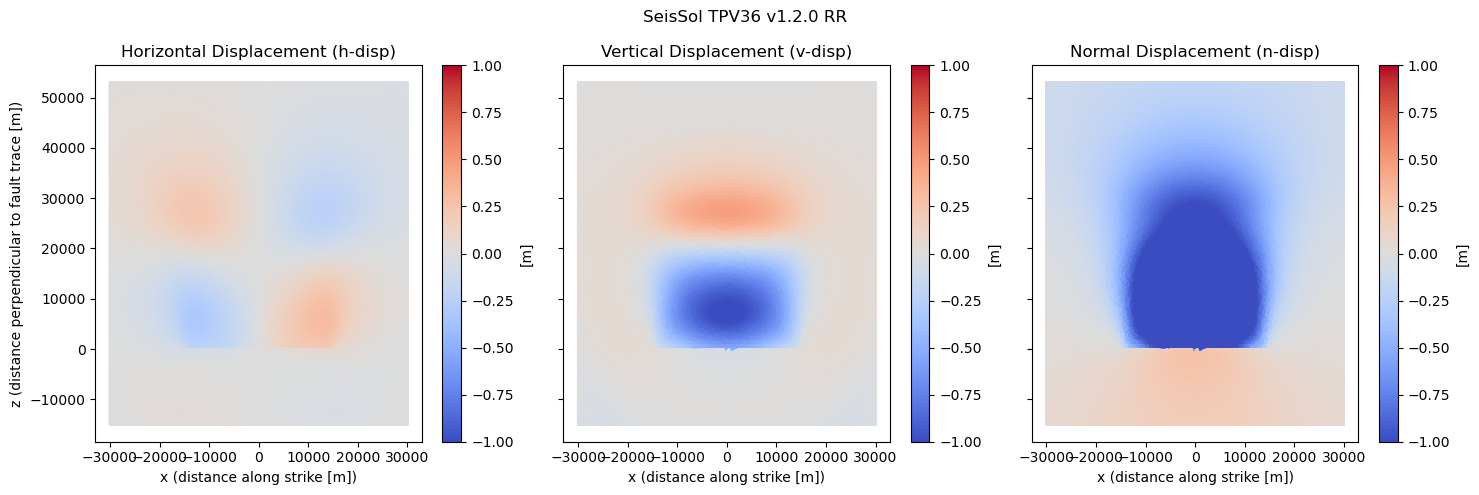

In [17]:
surface_plot(df, title="SeisSol TPV36 v1.2.0 RR", save=True)

## Barall

In [9]:
# Choose either
f_barall = pd.read_csv("/Users/fkutschera/Documents/Data/CRESCENT/tpv36_data/barall/surfdef.csv", sep="\s+", comment="#")
print("Max Uplift (m): {}".format(np.max(f_barall["v-disp"])))
print("Max Subsidence (m): {}".format(np.min(f_barall["v-disp"])))
print("Bounds: {}, {}, {}, {}".format(np.min(f_barall["x"]), np.max(f_barall["x"]), np.min(f_barall["z"]), np.max(f_barall["z"])))

Max Uplift (m): 0.4689249
Max Subsidence (m): -1.020885
Bounds: -30000.0, 30000.0, -15000.0, 53000.0


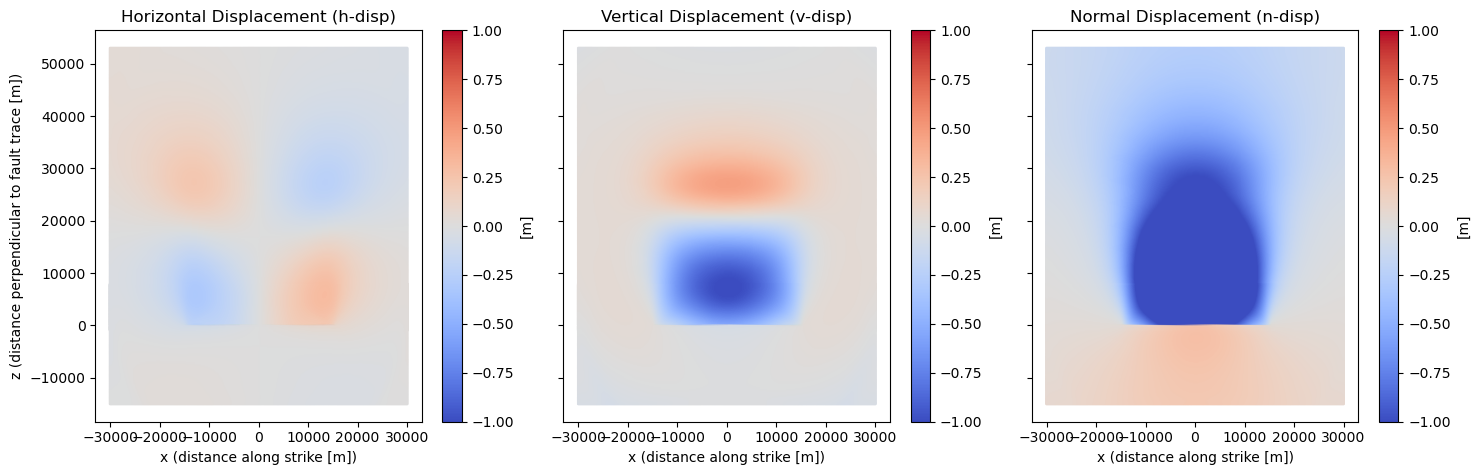

In [10]:
surface_plot(f_barall)

In [11]:
# or
#f_barall = pd.read_csv("/Users/fkutschera/Documents/Data/CRESCENT/tpv37_data/barall/barall_tpv37_c08_surfdef.txt", sep="\s+", comment="#")
f_barall = pd.read_csv("/Users/fkutschera/Documents/Data/CRESCENT/tpv36_data/barall/barall_tpv36_c07_surfdef.txt", sep="\s+", comment="#")
print("Max Uplift (m): {}".format(np.max(f_barall["v-disp"])))
print("Max Subsidence (m): {}".format(np.min(f_barall["v-disp"])))
print("Bounds: {}, {}, {}, {}".format(np.min(f_barall["x"]), np.max(f_barall["x"]), np.min(f_barall["z"]), np.max(f_barall["z"])))

Max Uplift (m): 0.4689249
Max Subsidence (m): -1.020885
Bounds: -30000.0, 30000.0, -15000.0, 53000.0


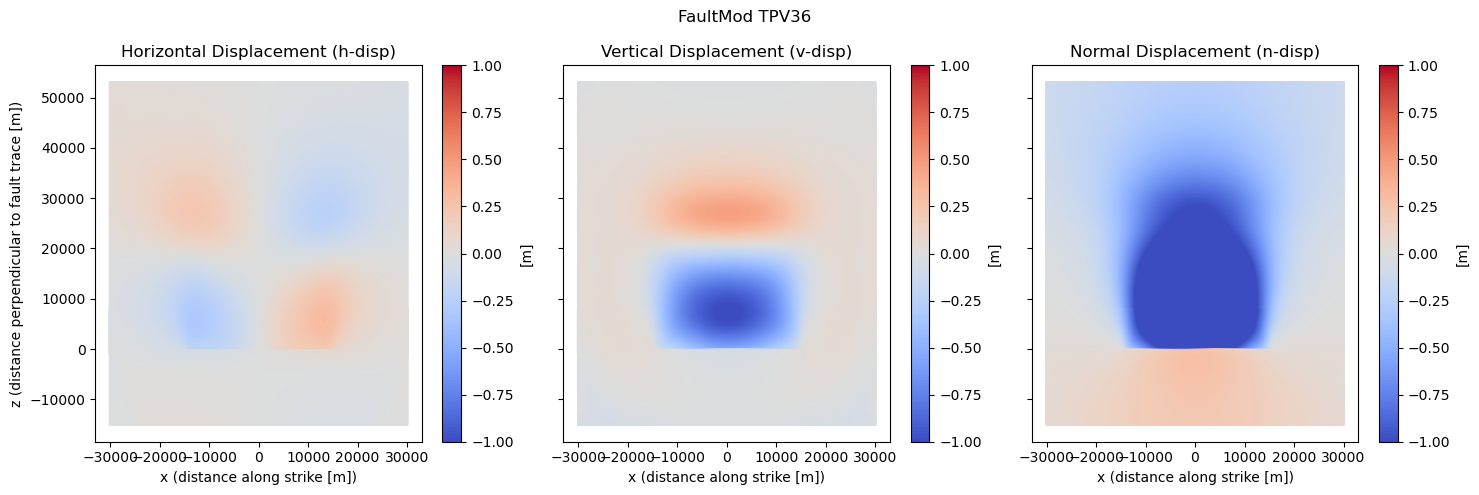

In [13]:
surface_plot(f_barall, title="FaultMod TPV36", save=False)